# Convolutional Network in Keras

Convolutional neural networks (CNN) play an important part in modern machine learning applications as they allow us to automatically analyze a wide range of data such as images or text. CNNs are used to detect features of the data automatically, for example, if an image is analyzed by a CNN, the CNN can be trained to tell cats apart from dogs.

A well known practice dataset for image recognition is the MNIST dataset The data contain a large number of handwritten digits in the range 0 - 9 and the task focuses on recognizing the images. The task was pioneered by Yann LeCun and others in 1998 ([original paper](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf) [Yann LeCun's Webpage for MNIST](http://yann.lecun.com/exdb/lenet/)). 

The images are snippets of 28 pixels x 28 pixels = 784 pixels and there are n=10 digits to recognize.

In [ ]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import datetime as dt
from sklearn.metrics import confusion_matrix

%pylab inline
# large figures
rcParams['figure.figsize'] = 8, 6

print(tf.__version__)

Populating the interactive namespace from numpy and matplotlib
2.2.0-rc4


## Loading the Data

As this is a popular dataset to get to know CNNs, the data are available as part of TensorFlow:

There are 6,000 images available, each with a size of 28x28 pixels.
The "shape" of the dataset is therefore $(28,28)$.

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
print(x_train.shape)

11493376/11490434 [==============================] - 0s 0us/step
(60000, 28, 28)


The images look like this:

True label: 3


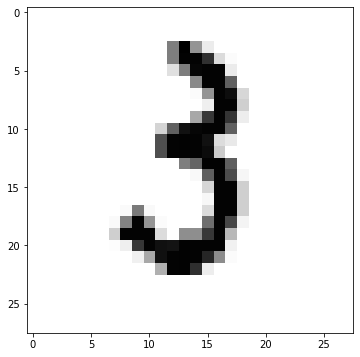

In [ ]:
index = 1234
print('True label: {}'.format(y_train[index]) )
plt.imshow(x_train[index], cmap='Greys')
plt.show()

First, we make the shape of the input tensor we will use in our model explicit:
 * length of the trainings and test tensor
 * 28x28 pixels
 * grayscale (1 colour)

We also need to normalize the color range by dividing by 255 (RGB range).
In addition, we cast the values to floating point numbers with 32-bit accuracy so they all have a well-defined state.

In [ ]:
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32')
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1).astype('float32')


x_train = x_train/255
x_test = x_test/255

print('Final shape of input tensor {}'.format(x_train.shape))


Final shape of input tensor (60000, 28, 28, 1)


## A Simple Model

We start with a very simple model that has only one convolutional layer.
We then add one fully connected (or dense) layer with ReLU activation function 
and then use a fully connected layer with 10 nodes (one for each digit in $0,\ldots,9$)
with softmax activation. The latter converts the output of the nodes into a probability.

We also add a dropout layer after the first fully connected layer to regularize the network.
Remember that we have to ["flatten"](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten) the last convolutional layer to sqash the image structure into a long, one-dimensional feature vector that is processed by the fully-connected layer.

Using the Keras interface, the model is then:

In [ ]:
model = tf.keras.Sequential(name='SimpleModel')
model.add(tf.keras.layers.Conv2D(filters=32, 
                                 kernel_size=(3,3), 
                                 strides=(1,1),
                                 padding='valid',
                                 activation='relu', 
                                 input_shape=(28,28,1)))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# flatten the 2D convolution layers before adding a fully connected (dense) layer
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128,activation=tf.nn.relu))

#add dropout for regularisation
model.add(tf.keras.layers.Dropout(0.5))

# final fully connected (dense) layer which returns a probability for each of the digits 0...9
model.add(tf.keras.layers.Dense(10,activation=tf.nn.softmax))


model.summary()

Model: "SimpleModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_42 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_42 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
flatten_26 (Flatten)         (None, 5408)              0         
_________________________________________________________________
dense_52 (Dense)             (None, 128)               692352    
_________________________________________________________________
dropout_26 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_53 (Dense)             (None, 10)                1290      
Total params: 693,962
Trainable params: 693,962
Non-trainable params: 0
_________________________________________________

Note that even this simple model has almost 700,000 free parameters (network weights) that need to be optimized.

We now specify how we train the network.
We need to specify the optimizer used during training. Several choices exist, as a good practice, the Adam Optimizer (See the [paper](https://arxiv.org/abs/1412.6980) and the [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam) for more details) is a good starting point.

We also use cross-entropy for the loss function as this is a classification problem.

Furthermore, we add the accuracy as the metric we want to monitor during network training.


In [ ]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy()]
)

We then train the model by calling ```model.fit()``` using 15 epochs to complete the training quickly. We also use a batch_size of 32, i.e., the images are presented to the network in batches of 32.

We store the history of the training process in the ```history``` object
in order to plot the values of the loss function and the accuracy during the training process afterwards.

In [ ]:
history = model.fit(x_train,y_train, epochs=15, batch_size=32)

Epoch 1/15
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2310 - sparse_categorical_accuracy: 0.9314
Epoch 2/15
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0936 - sparse_categorical_accuracy: 0.9717
Epoch 3/15
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0694 - sparse_categorical_accuracy: 0.9789
Epoch 4/15
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0586 - sparse_categorical_accuracy: 0.9821
Epoch 5/15
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0480 - sparse_categorical_accuracy: 0.9847
Epoch 6/15
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0403 - sparse_categorical_accuracy: 0.9876
Epoch 7/15
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0351 - sparse_categorical_accuracy: 0.9883
Epoch 8/15
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0308 - sparse_categorical_accuracy: 0.9901
Epoch 9/15
1875/1875 [==========

Keras also provides a convenient function to evaluate the performance on the independent test data we have retained.

In [ ]:
model.evaluate(x_test,y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.0467 - sparse_categorical_accuracy: 0.9881


[0.04666171967983246, 0.988099992275238]

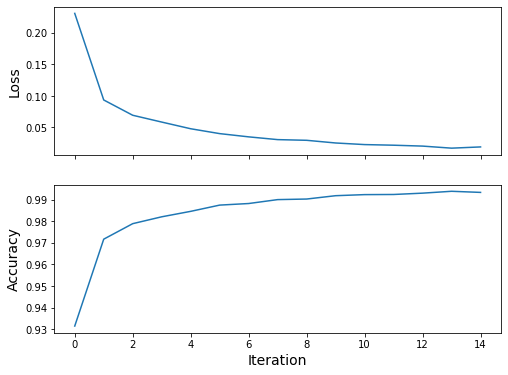

In [ ]:
history_dict = history.history
history_dict.keys()
loss_values = history_dict['loss']
acc_values = history_dict['sparse_categorical_accuracy']
epochs = range(1, len(loss_values) + 1)

fig, axes = plt.subplots(2, sharex=True)
axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(loss_values)
axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Iteration", fontsize=14)
axes[1].plot(acc_values)
plt.show()

The model achieves an accuracy of about 99% on an independent test sample, which is ok for a simple model. More complex models can achieve even higher accuracies, a summary can be found on Yann LeCuns [MNIST page](http://yann.lecun.com/exdb/mnist/index.html)

We can also make some predictions and look at the confusion matrix.

In [ ]:
predictions = model.predict(x_test)
y_hat = tf.argmax(predictions, axis=1)

[[ 976    1    0    0    0    1    1    1    0    0]
 [   0 1128    3    2    0    1    0    1    0    0]
 [   1    0 1023    1    0    0    1    5    1    0]
 [   0    0    1 1002    0    3    0    3    1    0]
 [   0    0    2    0  966    0    4    0    1    9]
 [   2    0    1    7    0  877    5    0    0    0]
 [   4    2    1    0    1    2  946    0    2    0]
 [   0    2    8    0    0    0    0 1014    1    3]
 [   4    0    2    1    0    1    0    1  960    5]
 [   0    1    0    3    6    2    0    4    4  989]]


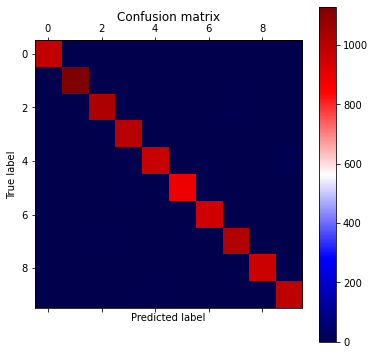

In [ ]:
# Compute confusion matrix
cm = confusion_matrix(y_test,y_hat)

print(cm)

# Show confusion matrix 
plt.matshow(cm, cmap='seismic')
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# A More Complex Model

We now create a more complex model by adding two convolutional layers and increasing the number of nodes in the intermediate fully connected layer.
Let's also train a bit longer.

In [ ]:
model2 = tf.keras.Sequential(name='ComplexModel')
model2.add(tf.keras.layers.Conv2D(filters=32,    kernel_size=(5,5), strides=(1,1), padding='same', activation=tf.nn.relu,  input_shape=(28,28,1)))
model2.add((tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2)))
model2.add(tf.keras.layers.Conv2D(filters=64,    kernel_size=(5,5), strides=(1,1), padding='same', activation=tf.nn.relu))
model2.add((tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2)))
model2.add((tf.keras.layers.Flatten()))
model2.add((tf.keras.layers.Dense(1024, activation=tf.nn.relu)))
model2.add((tf.keras.layers.Dropout(0.5)))
model2.add(tf.keras.layers.Dense(10,activation=tf.nn.softmax))


model2.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics = [tf.keras.metrics.SparseCategoricalAccuracy()])

model2.summary()

Model: "ComplexModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_37 (Conv2D)           (None, 28, 28, 32)        832       
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 14, 14, 64)        51264     
_________________________________________________________________
max_pooling2d_38 (MaxPooling (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_22 (Flatten)         (None, 3136)              0         
_________________________________________________________________
dense_44 (Dense)             (None, 1024)              3212288   
_________________________________________________________________
dropout_22 (Dropout)         (None, 1024)             

Note how just this moderate increase in complexity increased the number of parameters from around 700,000 to more than 3 million.

In [ ]:
history = model2.fit(x_train, y_train, epochs=15, batch_size=32)

Epoch 1/15
1875/1875 [==============================] - 13s 7ms/step - loss: 0.1163 - sparse_categorical_accuracy: 0.9638
Epoch 2/15
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0419 - sparse_categorical_accuracy: 0.9871
Epoch 3/15
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0325 - sparse_categorical_accuracy: 0.9900
Epoch 4/15
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0238 - sparse_categorical_accuracy: 0.9923
Epoch 5/15
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0190 - sparse_categorical_accuracy: 0.9942
Epoch 6/15
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0175 - sparse_categorical_accuracy: 0.9946
Epoch 7/15
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0140 - sparse_categorical_accuracy: 0.9955
Epoch 8/15
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0104 - sparse_categorical_accuracy: 0.9968
Epoch 9/15
1875/1875 [==

In [ ]:
model2.evaluate(x_test,y_test)

313/313 [==============================] - 1s 4ms/step - loss: 0.0527 - sparse_categorical_accuracy: 0.9929


[0.05265460163354874, 0.992900013923645]

We note that this slightly more complex model (which has  significantly more parameters) is slightly better. On an independent test sample,
we have improved the initial accuracy from approximately 0.9881 to  0.9929.

This shows  that it will be quite difficult to determine a network architecture that can further improve the performance, and quite a lot of
work and thinking is required to design even more powerful architectures.

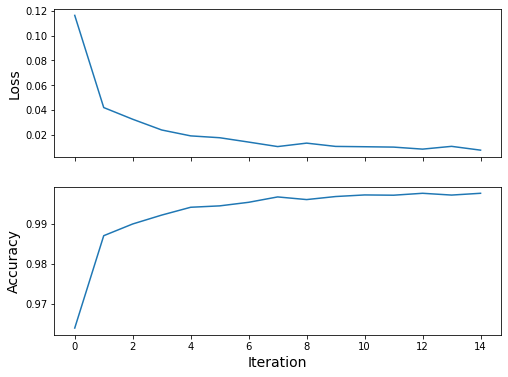

In [ ]:
history_dict = history.history
history_dict.keys()
loss_values = history_dict['loss']
acc_values = history_dict['sparse_categorical_accuracy']
epochs = range(1, len(loss_values) + 1)

fig, axes = plt.subplots(2, sharex=True)
axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(loss_values)
axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Iteration", fontsize=14)
axes[1].plot(acc_values)
plt.show()